In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
import time
import warnings as w
import plotly.plotly as py
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

def qualityRMSE(x,y):
    return (((x-y)**2).mean())**(0.5)

def qualitySSE(x,y):
    return ((x-y)**2).sum()

/home/daniel/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts_data = pd.read_csv('train.csv', sep=',', decimal='.', index_col='Date', parse_dates=True, dayfirst=True)

In [3]:
ts=[]
indexes=[]
end1s=[]
end2s=[]
for i in range(1,23):
    ts.append(ts_data[ts_data['tsID']==i])
#     ts[i-1].plot(figsize=(15,3))
    end1s.append(len(ts[i-1]['ACTUAL'].dropna()))
    end2s.append(len(ts[i-1]))
    indexes.append(ts[i-1][ts[i-1]['ACTUAL'].replace(np.nan,0)==0]['ID'])

In [22]:
def logistic_regression(X, Y):
    beta = np.linalg.inv(X.T.dot(X) + 7000*np.identity(len(X[0]))).dot(X.T).dot(Y)
    return beta

In [23]:
SEs=[]
lenq=[]
for i in range(len(ts)):
    print(i)
#     exogs1 = ts[i].loc[:,['ACTUAL']].replace(np.nan,0)[:364]
    exogs1 = ts[i].loc[:,['ACTUAL','Saturday','Sunday']].replace(np.nan,0)[:364]
    exogs1['Temp']=(ts[i].loc[:,['Temp']]+50).replace(np.nan,0)[:364]
#     exogs1['Temp2']=exogs1['Temp']**2
#     exogs1['Temp3']=exogs1['Temp']**3
#     exogs1['Temp4']=exogs1['Temp']**4
#     exogs1['AC/Temp']=exogs1['ACTUAL']/exogs1['Temp']
#     exogs1['AC2/Temp2']=exogs1['AC/Temp']**2
#     exogs1['AC2/Temp3']=exogs1['AC/Temp']**3
#     exogs1['AC2/Temp4']=exogs1['AC/Temp']**4
    
    exogs1['1ACTUAL'] = np.array(ts[i].loc[:,['ACTUAL']].replace(np.nan,0)[364:728])
    exogs1['1Saturday'] = np.array(ts[i].loc[:,['Saturday']].replace(np.nan,0)[364:728])
    exogs1['1Sunday'] = np.array(ts[i].loc[:,['Sunday']].replace(np.nan,0)[364:728])
    exogs1['1Temp']=np.array((ts[i].loc[:,['Temp']]+50).replace(np.nan,0)[364:728])
    exogs1['Ac-1']=np.hstack((np.array((ts[i].loc[:,['ACTUAL']]).replace(np.nan,0)[727:]).reshape(-1),np.zeros(1091-len(ts[i]))))*(1-0.1*np.random.normal(-0.5,0.5,364))
    exogs1['Ac-2']=np.hstack((np.array((ts[i].loc[:,['ACTUAL']]).replace(np.nan,0)[726:]).reshape(-1),np.zeros(1090-len(ts[i]))))

    
    exogs1['2Saturday']=np.hstack((np.array((ts[i].loc[:,['Saturday']]).replace(np.nan,0)[728:]).reshape(-1),np.zeros(1092-len(ts[i]))))
    exogs1['2Sunday']=np.hstack((np.array((ts[i].loc[:,['Sunday']]).replace(np.nan,0)[728:]).reshape(-1),np.zeros(1092-len(ts[i]))))
    exogs1['temp_self']=np.hstack((np.array((ts[i]['Temp']-ts[i]['Temp'].shift(364)).replace(np.nan,0)[728:]).reshape(-1),np.zeros(1092-len(ts[i]))))
#     exogs1['temp_self1']=np.hstack((np.array((ts[i]['Temp']-ts[i]['Temp'].shift(1)).replace(np.nan,0)[728:]).reshape(-1),np.zeros(1092-len(ts[i]))))

    
#     exogs1['1Temp2']=exogs1['1Temp']**2
#     exogs1['1Temp3']=exogs1['1Temp']**3
#     exogs1['1Temp4']=exogs1['1Temp']**4
#     exogs1['1AC/Temp']=exogs1['1ACTUAL']/exogs1['1Temp']
#     exogs1['1AC2/Temp2']=exogs1['1AC/Temp']**2
#     exogs1['1AC2/Temp3']=exogs1['1AC/Temp']**3
#     exogs1['1AC2/Temp4']=exogs1['1AC/Temp']**4
    exogs1['Ones']=np.ones(len(exogs1))
    

    Y=np.array(ts[i]['ACTUAL'][728:len(ts[i])-30])
    
    X=np.array(exogs1[:len(Y)])
    start=len(ts[i])-30-728
    end=len(ts[i])-728
    
    beta=logistic_regression(X,Y)
    

    Y_pred=[]
    for j in range(30):
        Y_pred.append(beta.dot(exogs1.iloc[start+j].T))
        exogs1['Ac-1'][start+1+j]=Y_pred[j]
        if j >0:
            exogs1['Ac-2'][start+1+j]=Y_pred[j-1]

    
    csv = np.column_stack((indexes[i],Y_pred))
    np.savetxt("{}.csv".format(i), csv, delimiter=",")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [24]:
csvs=[]
for i in range(22):
    csvs.append(pd.read_csv('{}.csv'.format(i), sep=',', decimal='.', header=-1))

concate=pd.concat(csvs)
concate[0]=concate[0].astype(int)
concate.to_csv('concate.csv', index = False, header=(['ID','PREDICTED']))

In [25]:
concate

,0,1
0,16707,104210.909833
1,16708,98581.212895
2,16709,97742.114613
3,16710,96541.496856
4,16711,103411.800724
5,16712,106369.262660
6,16713,109205.754691
7,16714,109649.506985
8,16715,109731.317528
9,16716,104032.806141


In [ ]:
ts[15]=ts[15].resample('D').mean()

SEs=[]

for i in range(10,len(ts)):
    print(i)
    end1=end1s[i]-30
    end2=end2s[i]-30
    
    exogs = ts[i].loc[:,['Temp','Saturday','Sunday']].replace(np.nan,0)
    exogs['Temp-1']=exogs['Temp'].shift(1).replace(np.nan,0)
#     exogs['Temp-365']=exogs['Temp'].shift(365).replace(np.nan,0)

    mod = sm.tsa.statespace.SARIMAX(ts[i]['ACTUAL'].iloc[:end1], exog=exogs.iloc[:end1], order=(1,1,6), seasonal_order=(1,0,0,364)).fit()
    
    pred=mod.predict(start=end1, end=end2-1, exog=exogs[end1:end2])
    print(qualityRMSE(pred,ts[i]['ACTUAL'].iloc[end1:]))


    SEs.append(qualitySSE(pred,ts[i]['ACTUAL'].iloc[end1:end2]))
    csv = np.column_stack((indexes[i],pred))
    np.savetxt("{}.csv".format(i), csv, delimiter=",")
    break

10


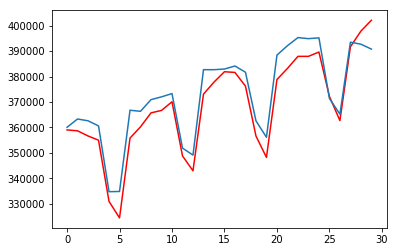

In [18]:
# ts[i]['ACTUAL'].iloc[end1-365:end2-365].plot()
# ts[i]['ACTUAL'].iloc[end1:end2].plot()

plt.plot(np.array(ts[i]['ACTUAL'].iloc[end1:end2]), color='r')
plt.plot(np.array(ts[i]['ACTUAL'].iloc[end1-364:end2-364]))
plt.show()

In [208]:
(sum(SEs)/660)**0.5

6760.5079750897103

In [179]:
csvs=[]
for i in range(22):
    csvs.append(pd.read_csv('{}.csv'.format(i), sep=',', decimal='.', header=-1))

concate=pd.concat(csvs)
concate[0]=concate[0].astype(int)
concate.to_csv('concate.csv', index = False, header=(['ID','PREDICTED']))